# Core Imports

In [32]:
# Generic Imports
import re
from functools import partial, cached_property
from collections import defaultdict
from itertools import combinations, chain
from ast import literal_eval

# Numeric imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# File I/O
from pathlib import Path
import csv, json, openpyxl

# Typing and Subclassing
from typing import Any, Callable, ClassVar, Generator, Iterable, Optional, Union
from dataclasses import dataclass, field
from abc import ABC, abstractmethod, abstractproperty
from openmm.unit import Unit, Quantity

# Cheminformatics
from rdkit import Chem
from rdkit.Chem import rdChemReactions
from rdkit.Chem.Draw import IPythonConsole

import pubchempy as pcp

DIM    = 300
ASPECT = 3/2
IPythonConsole.molSize = (int(ASPECT*DIM), DIM)   # Change image size

# Static Paths
RAW_DATA_DIR  = Path('monomer_data_raw')
FMT_DATA_DIR  = Path('monomer_data_formatted')
PROC_DATA_DIR = Path('monomer_data_processed')
RXN_FILES_DIR = Path('poly_rxns')

# Inspecting monomer dataset

In [33]:
# input_data_path = FMT_DATA_DIR / '20231114_polyid_data_density_DP2-6 - 1,2 monomers.csv'
# input_data_path = FMT_DATA_DIR / 'polyurethanes.csv'
# input_data_path = PROC_DATA_DIR / '20231114_polyid_data_density_DP2-6 - 1,2 monomers_FILTERED.csv'
input_data_path = FMT_DATA_DIR / '221010_trainingdata_DP-18_expanded_FMT.csv'
df = pd.read_csv(input_data_path, index_col=0)
len(df)

2618

In [34]:
df

,Unnamed: 0,hash-monomers-distribution,monomers,distribution,mechanism,Glass_Transition,Melt_Temp,Cp_solid_slope,Cp_solid_intercept,Cp_liquid_slope,...,log10_Permeability_CH4,log10_Permeability_CO2,log10_Permeability_N2,log10_Permeability_O2,log10_Permeability_H2,log10_Permeability_H2O,smiles_polymer,hash-smiles_polymer,smiles_monomer,replicate_structure
0,3,28NNnPqUqeUNrtmudNTwYz,"('CC(C)(C)c1cc(C(=O)O)cc(C(=O)O)c1', 'Nc1ccc(-...",NaN,amide,275.00,NaN,NaN,NaN,NaN,...,0.359835,1.743588,0.376577,1.148911,NaN,NaN,CC(C)(C)c1cc(C(=O)O)cc(C(=O)Nc2ccc(-c3ccc(Oc4c...,Zzhk9gU8ApTH4xtAfQi5rW,CC(C)(C)c1cc(C(=O)O)cc(C(=O)O)c1.Nc1ccc(-c2ccc...,0
1,5,28oL8vgvwP9acaZDehEMGU,"('O=C(O)c1cccc(C(=O)O)c1', 'Nc1ccc(Oc2ccc(Oc3c...",NaN,amide,210.00,340.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Nc1ccc(Oc2ccc(Oc3ccc(NC(=O)c4cccc(C(=O)Nc5ccc(...,MmKrS7QZesi5QHFkPtKreE,O=C(O)c1cccc(C(=O)O)c1.Nc1ccc(Oc2ccc(Oc3ccc(N)...,0
2,11,2DuicAyoesWbNJNz3MgSWn,"('NCCCCCCCCCN', 'O=C(O)CCCCCCCC(=O)O')",NaN,amide,NaN,177.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NCCCCCCCCCNC(=O)CCCCCCCC(=O)NCCCCCCCCCNC(=O)CC...,DRQdStFNSgFv3wedj6sZz7,NCCCCCCCCCN.O=C(O)CCCCCCCC(=O)O,0
3,12,2EvjUqRRk9goyUTA69A7P7,"('O=C(O)c1cc(C(=O)O)cc([N+](=O)[O-])c1', 'Nc1c...",NaN,amide,174.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Nc1ccc(O[Si](Oc2ccc(NC(=O)c3cc(C(=O)Nc4ccc(O[S...,X5mKgKyx8EJHc7TzcxMexM,O=C(O)c1cc(C(=O)O)cc([N+](=O)[O-])c1.Nc1ccc(O[...,0
4,15,2HpYXrCFgaJVszCPDtpWsv,"('Nc1ccc(N)cc1', 'O=C(O)c1cccc(N2C(=O)c3ccc(C(...",NaN,amide,315.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Nc1ccc(NC(=O)c2cccc(N3C(=O)c4ccc(C(c5ccc6c(c5)...,KUoF3Vr4pohJzC9MzUW59q,Nc1ccc(N)cc1.O=C(O)c1cccc(N2C(=O)c3ccc(C(c4ccc...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2613,2584,o3GGTNZkgNEuQSKNWYeYFs,"('C=CC',)",NaN,vinyl,-9.15,NaN,0.25,-0.85,0.15,...,NaN,1.231736,0.079965,0.755046,NaN,2.053483,CC(CCC(C)CC(C)CC(C)C(C)CCC(C)C(C)CC(C)CCC(C)C(...,6232Wkx4QGKYgD6kxuodTj,C=CC,0
2614,2588,o4LroNwi3uKoY2oXtjDvau,"('C=CC(=O)OCCCCCCCCCCCCCC',)",NaN,vinyl,NaN,28.0,NaN,NaN,NaN,...,1.813581,2.472756,1.344392,1.756636,1.983175,NaN,CCCCCCCCCCCCCCOC(=O)CCCC(C(=O)OCCCCCCCCCCCCCC)...,jeytmhnbvwNCi9TFJzb3Sh,C=CC(=O)OCCCCCCCCCCCCCC,0
2615,2592,o8CKTqDchhSvCTx6NLc6ih,"('C=C(C#N)C(=O)OCCCCCCCC',)",NaN,vinyl,48.85,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,CCCCCCCCOC(=O)C(C#N)CC(C#N)(CCC(C#N)(CC(C#N)(C...,HMUpFTATpJVVYZG2zsywgy,C=C(C#N)C(=O)OCCCCCCCC,0
2616,2605,oNVVbZgL7r4BMQkoTzruM3,"('C=Cc1ccc(C)cc1C',)",NaN,vinyl,112.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Cc1ccc(CCCC(c2ccc(C)cc2C)C(CC(CCC(c2ccc(C)cc2C...,T4Fmiy6gWwfj7bntRHUzGX,C=Cc1ccc(C)cc1C,0


## Sort by polymerization mechanism and #monomers, obtain respective counts and colors

In [35]:
df.smiles_monomer

0       CC(C)(C)c1cc(C(=O)O)cc(C(=O)O)c1.Nc1ccc(-c2ccc...
1       O=C(O)c1cccc(C(=O)O)c1.Nc1ccc(Oc2ccc(Oc3ccc(N)...
2                         NCCCCCCCCCN.O=C(O)CCCCCCCC(=O)O
3       O=C(O)c1cc(C(=O)O)cc([N+](=O)[O-])c1.Nc1ccc(O[...
4       Nc1ccc(N)cc1.O=C(O)c1cccc(N2C(=O)c3ccc(C(c4ccc...
                              ...                        
2613                                                 C=CC
2614                              C=CC(=O)OCCCCCCCCCCCCCC
2615                               C=C(C#N)C(=O)OCCCCCCCC
2616                                      C=Cc1ccc(C)cc1C
2617                                       C=C1CC(C)OC1=O
Name: smiles_monomer, Length: 2618, dtype: object

In [36]:
from polymerist.graphics import plotutils

if 'num_monomers' not in df.columns:
    df['num_monomers'] = df.smiles_monomer.map(lambda smiles : len(smiles.split('.')))

# keys = ['num_monomers', 'mechanism']
keys = ['mechanism', 'num_monomers']

df_grouper = df.groupby(keys)
frames = {
    mech : df_grouper.get_group(mech)
        for mech in df_grouper.groups
}

In [37]:
counts = df_grouper.size().to_dict()
cdict, carr = plotutils.label_discrete_cmap(
    cmap=plt.get_cmap('tab10'),
    color_names=df.mechanism.unique(),
    hues_per_color=1
)

In [38]:
counts

{('NIPU', 2): 52,
 ('amide', 1): 20,
 ('amide', 2): 548,
 ('amide', 3): 4,
 ('carbonate', 2): 58,
 ('carbonate', 3): 6,
 ('ester', 1): 23,
 ('ester', 2): 367,
 ('ester', 3): 95,
 ('imide', 2): 771,
 ('imide', 3): 1,
 ('urethane', 2): 63,
 ('urethane', 3): 1,
 ('vinyl', 1): 553,
 ('vinyl', 2): 44,
 ('vinyl', 3): 10,
 ('vinyl', 4): 2}

In [41]:
colors = []
plot_counts = {}
for (mech, num_mono), count_val in counts.items():
    plot_counts[f'{mech}-{num_mono}'] = count_val
    colors.append(cdict[mech])

### Plot Histogram by number of monomers and mechanism

Text(0.5, 1.0, 'Number of SMILES by mechanism & num_monomers (2618 total)')

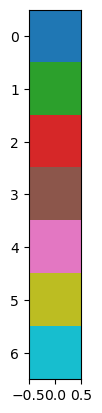

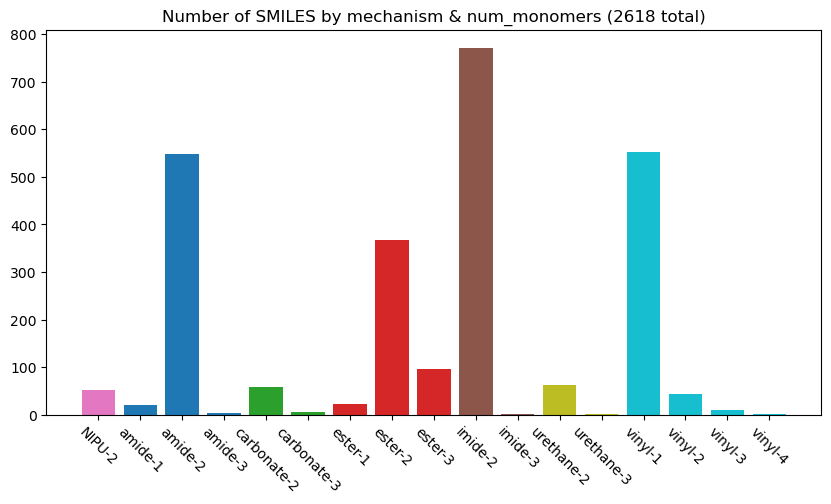

In [42]:
plt.imshow(carr)

plotutils.presize_subplots(1, 1, scale=10, elongation=1/2)

plt.bar(plot_counts.keys(), plot_counts.values(), color=colors)
plt.xticks(np.arange(len(counts))+0, rotation=-45)

plt.title(f'Number of SMILES by {" & ".join(keys)} ({len(df)} total)')

# Visually inspecting monomer and oligomer units


========================= carbonate-0 =========================



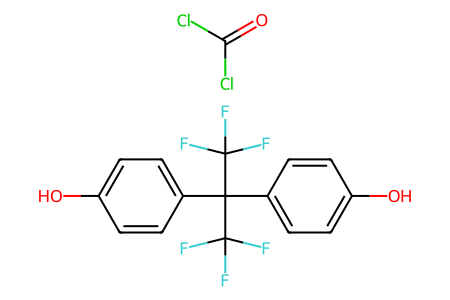

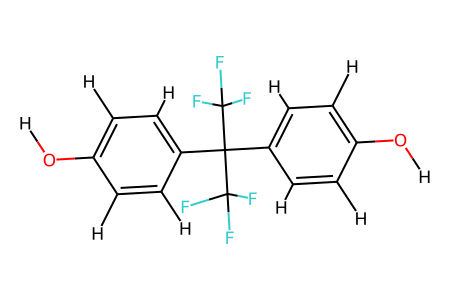

4-[1,1,1,3,3,3-hexafluoro-2-(4-hydroxyphenyl)propan-2-yl]phenol


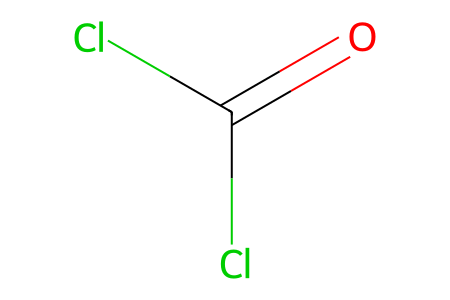

carbonyl dichloride

========================= carbonate-1 =========================



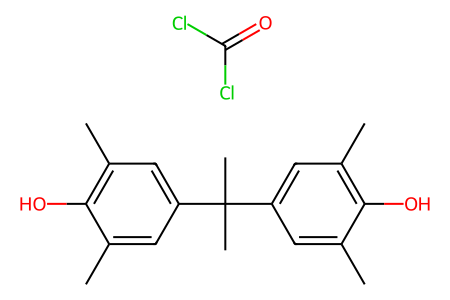

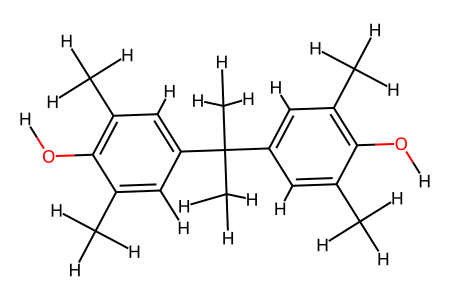

4-[2-(4-hydroxy-3,5-dimethylphenyl)propan-2-yl]-2,6-dimethylphenol


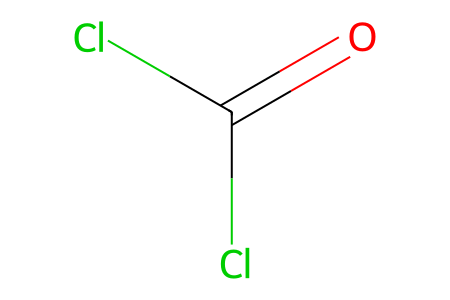

carbonyl dichloride

========================= carbonate-6 =========================



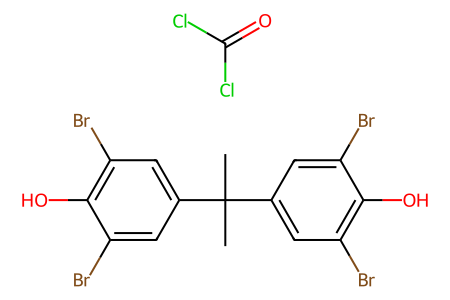

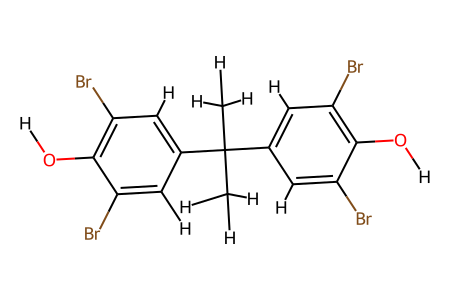

2,6-dibromo-4-[2-(3,5-dibromo-4-hydroxyphenyl)propan-2-yl]phenol


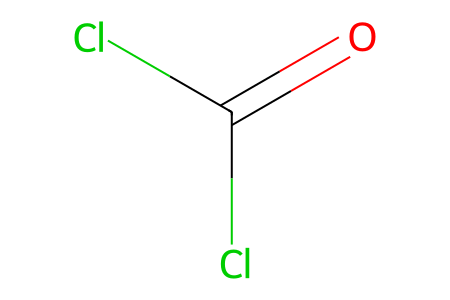

carbonyl dichloride

========================= carbonate-14 =========================



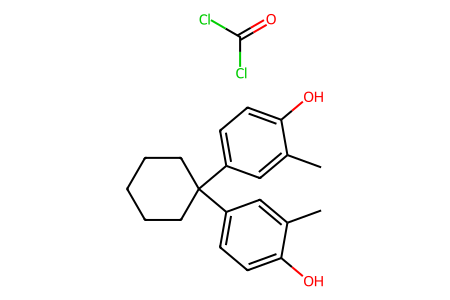

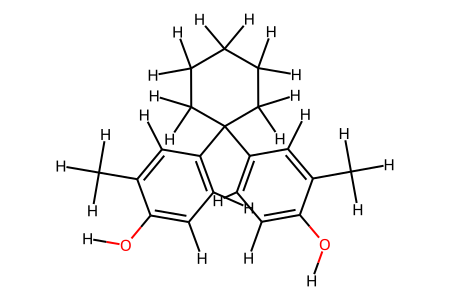

4-[1-(4-hydroxy-3-methylphenyl)cyclohexyl]-2-methylphenol


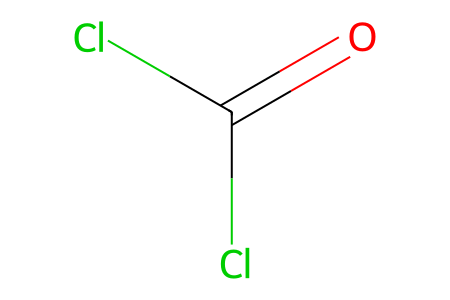

carbonyl dichloride

========================= carbonate-33 =========================



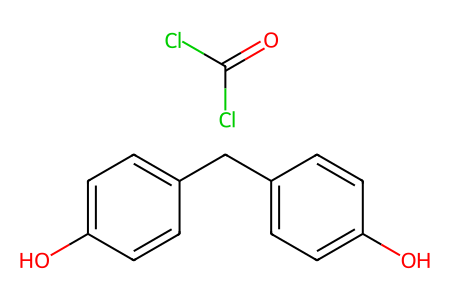

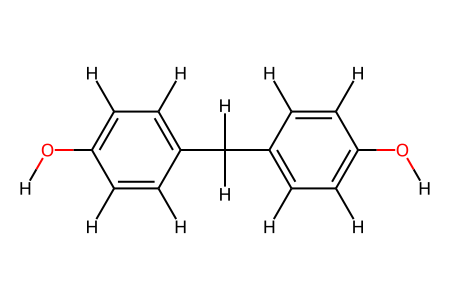

4-[(4-hydroxyphenyl)methyl]phenol


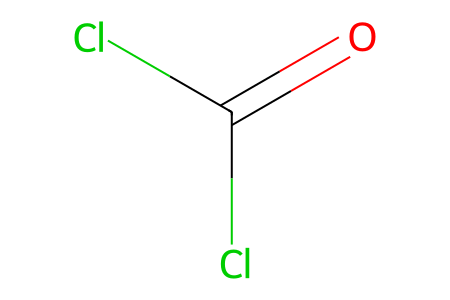

carbonyl dichloride

========================= carbonate-43 =========================



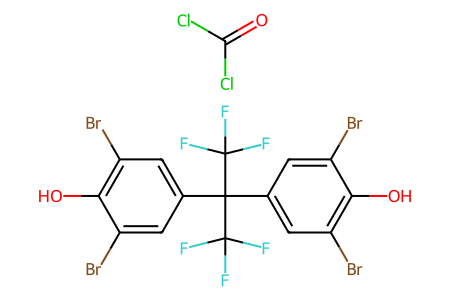

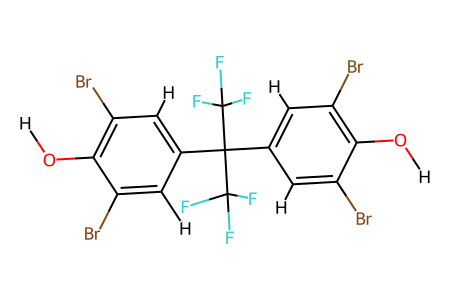

2,6-dibromo-4-[2-(3,5-dibromo-4-hydroxyphenyl)-1,1,1,3,3,3-hexafluoropropan-2-yl]phenol


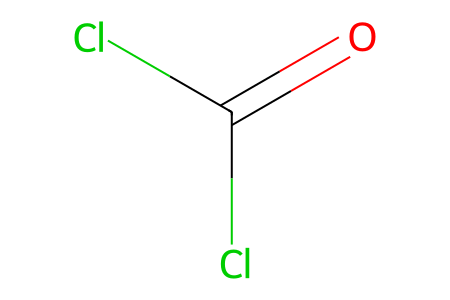

carbonyl dichloride

========================= carbonate-47 =========================



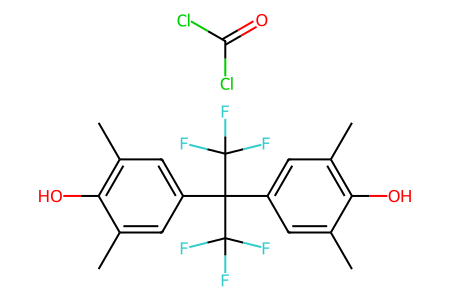

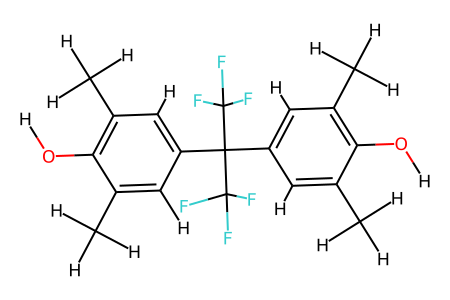

4-[1,1,1,3,3,3-hexafluoro-2-(4-hydroxy-3,5-dimethylphenyl)propan-2-yl]-2,6-dimethylphenol


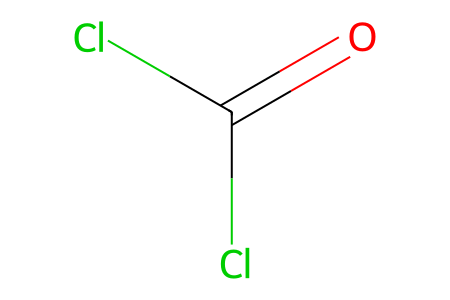

carbonyl dichloride

========================= carbonate-48 =========================



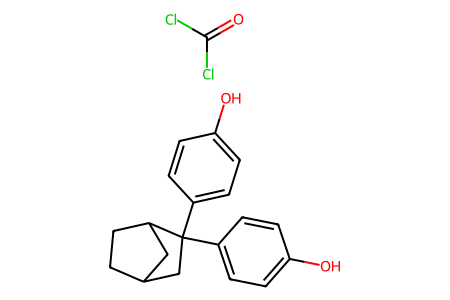

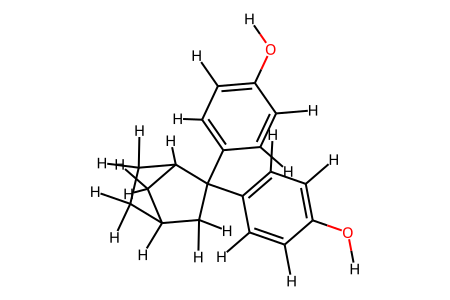

4-[2-(4-hydroxyphenyl)-2-bicyclo[2.2.1]heptanyl]phenol


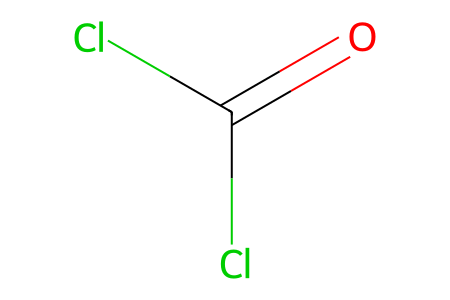

carbonyl dichloride

========================= carbonate-49 =========================



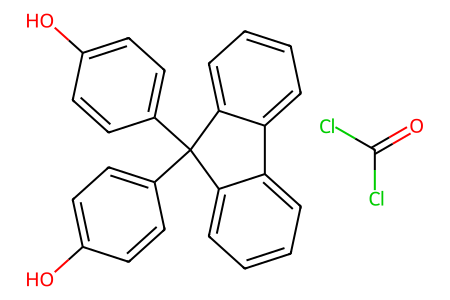

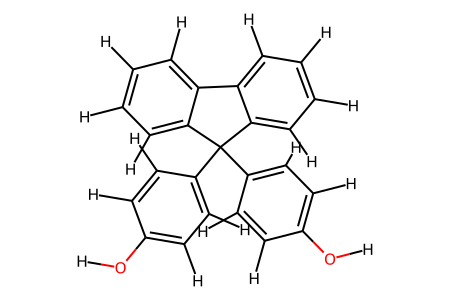

4-[9-(4-hydroxyphenyl)fluoren-9-yl]phenol


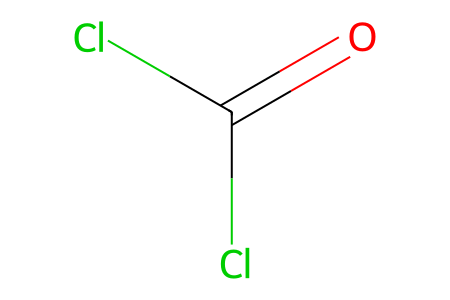

carbonyl dichloride

========================= carbonate-54 =========================



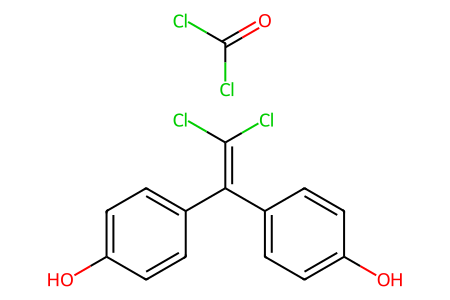

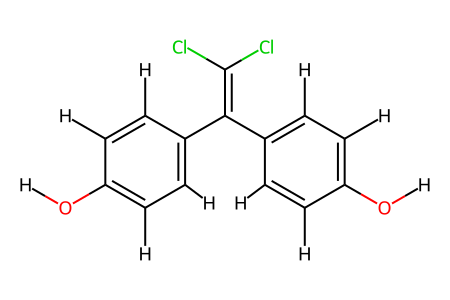

4-[2,2-dichloro-1-(4-hydroxyphenyl)ethenyl]phenol


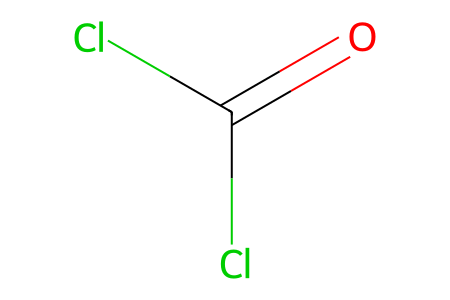

carbonyl dichloride


In [31]:
from polymerist.monomers import specification

# mech = 'ester'
mech = 'carbonate'
# mech = 'urethane'
# mech = 'vinyl'
# mech = 'imide'
num_mono = 2 # 1

frame = frames[(mech, num_mono)]

# ids = (23, 223)
ids = ()
n = 10
spacer = '=' * 25

test = defaultdict(list)
smaller = set()
for idx, row in frame.head(n).iterrows():
    if (not ids) or (idx in ids):
        # extract and visualize structures
        print(f'\n{spacer} {row["mechanism"]}-{idx} {spacer}\n')
        combined_smiles = row['smiles_monomer']
        combined_monomer = Chem.MolFromSmiles(combined_smiles, sanitize=False)
        display(combined_monomer)

        # dimer_smiles  = row['smiles_polymer_DP2']
        # dimer = Chem.MolFromSmiles(dimer_smiles)
        # display(dimer)

        # trimer_smiles = row['smiles_polymer_DP3']
        # trimer = Chem.MolFromSmiles(trimer_smiles)
        # display(trimer)

        for id in (1, 2):
            exp_mono_smi = row[f'smiles_expanded_monomer_{id}']
            monomer = Chem.MolFromSmiles(exp_mono_smi, sanitize=False)
            iupac_name = row[f'IUPAC_monomer_{id}']

            display(monomer)
            print(iupac_name)